<a href="https://colab.research.google.com/github/ankitajais20/Anime-face-generator/blob/main/Anime_Face_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pwd

/content


In [ ]:
! pip install kaggle

In [ ]:
! mkdir ~/.kaggle

mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download splcher/animefacedataset

 96% 377M/395M [00:02<00:00, 165MB/s]
100% 395M/395M [00:02<00:00, 174MB/s]


In [ ]:
! unzip animefacedataset -d animefacedataset

Streaming output truncated to the last 5000 lines.
  inflating: animefacedataset/images/62764_2019.jpg  
  inflating: animefacedataset/images/62765_2019.jpg  
  inflating: animefacedataset/images/62766_2019.jpg  
  inflating: animefacedataset/images/62767_2019.jpg  
  inflating: animefacedataset/images/62768_2019.jpg  
  inflating: animefacedataset/images/62769_2019.jpg  
  inflating: animefacedataset/images/6276_2003.jpg  
  inflating: animefacedataset/images/62770_2019.jpg  
  inflating: animefacedataset/images/62771_2019.jpg  
  inflating: animefacedataset/images/62772_2019.jpg  
  inflating: animefacedataset/images/62773_2019.jpg  
  inflating: animefacedataset/images/62774_2019.jpg  
  inflating: animefacedataset/images/62775_2019.jpg  
  inflating: animefacedataset/images/62776_2019.jpg  
  inflating: animefacedataset/images/62777_2019.jpg  
  inflating: animefacedataset/images/62778_2019.jpg  
  inflating: animefacedataset/images/62779_2019.jpg  
  inflating: animefacedataset/im

In [ ]:
import os

DATA_DIR = 'animefacedataset'
print(os.listdir(DATA_DIR))

['images']


In [ ]:
print(os.listdir(DATA_DIR+'/images')[:10])

['33365_2011.jpg', '4539_2003.jpg', '53779_2016.jpg', '59450_2018.jpg', '53569_2016.jpg', '61133_2018.jpg', '21980_2008.jpg', '7265_2004.jpg', '63030_2019.jpg', '57015_2017.jpg']


In [ ]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [ ]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [ ]:
train_ds = ImageFolder(DATA_DIR, transform=T.Compose([
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [ ]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


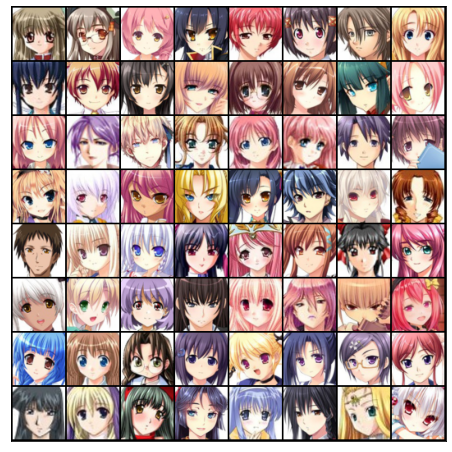

In [ ]:
show_batch(train_dl)

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
device = get_default_device()
device


device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)

In [ ]:
import torch.nn as nn

In [ ]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64

    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 128 x 16 x 16

    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 256 x 8 x 8

    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 512 x 4 x 4

    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    # out: 1 x 1 x 1

    nn.Flatten(),
    nn.Sigmoid())

In [ ]:
discriminator = to_device(discriminator, device)

In [ ]:
latent_size = 128

In [ ]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    # out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    # out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    # out: 3 x 64 x 64
)

torch.Size([128, 3, 64, 64])


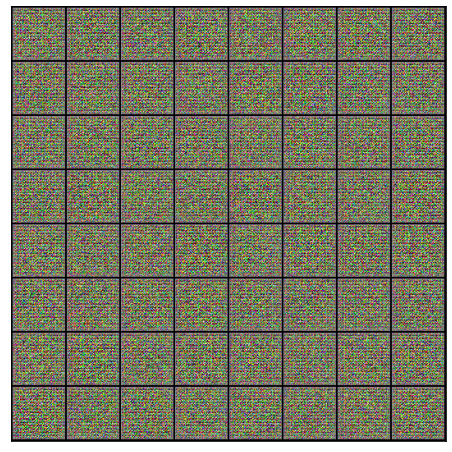

In [ ]:
xb = torch.randn(batch_size, latent_size, 1, 1) # random latent tensors
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [ ]:
generator = to_device(generator, device)

In [ ]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [ ]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()
    
    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)
    
    # Update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()

In [ ]:
from torchvision.utils import save_image

In [ ]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [ ]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [ ]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Saving generated-images-0000.png


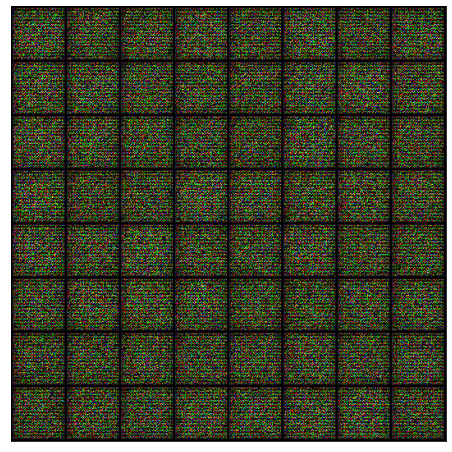

In [ ]:
save_samples(0, fixed_latent)

In [ ]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [ ]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
    
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)
    
    return losses_g, losses_d, real_scores, fake_scores

In [ ]:
lr = 0.0002
epochs = 25

In [ ]:
history = fit(epochs, lr)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))



Epoch [1/25], loss_g: 4.6771, loss_d: 0.2798, real_score: 0.8711, fake_score: 0.1065
Saving generated-images-0001.png



Epoch [2/25], loss_g: 5.5913, loss_d: 1.1400, real_score: 0.4264, fake_score: 0.0031
Saving generated-images-0002.png



Epoch [3/25], loss_g: 6.4530, loss_d: 0.4340, real_score: 0.9664, fake_score: 0.2956
Saving generated-images-0003.png



Epoch [4/25], loss_g: 5.5185, loss_d: 0.3241, real_score: 0.8991, fake_score: 0.1683
Saving generated-images-0004.png



Epoch [5/25], loss_g: 6.3944, loss_d: 0.2293, real_score: 0.8331, fake_score: 0.0125
Saving generated-images-0005.png



Epoch [6/25], loss_g: 5.4921, loss_d: 0.2648, real_score: 0.9014, fake_score: 0.1017
Saving generated-images-0006.png



Epoch [7/25], loss_g: 6.3773, loss_d: 0.1957, real_score: 0.8826, fake_score: 0.0115
Saving generated-images-0007.png



Epoch [8/25], loss_g: 7.6856, loss_d: 0.0584, real_score: 0.9865, fake_score: 0.0332
Saving generated-images-0008.png



Epoch [9/25], loss_g: 16.2264, loss_d: 0.7701, real_score: 0.6832, fake_score: 0.0000
Saving generated-images-0009.png



Epoch [10/25], loss_g: 9.1472, loss_d: 0.1160, real_score: 0.9902, fake_score: 0.0830
Saving generated-images-0010.png



Epoch [11/25], loss_g: 13.6554, loss_d: 0.0516, real_score: 0.9551, fake_score: 0.0000
Saving generated-images-0011.png



Epoch [12/25], loss_g: 10.6643, loss_d: 0.0141, real_score: 0.9901, fake_score: 0.0006
Saving generated-images-0012.png



Epoch [13/25], loss_g: 5.9557, loss_d: 0.0950, real_score: 0.9486, fake_score: 0.0226
Saving generated-images-0013.png



Epoch [14/25], loss_g: 10.0599, loss_d: 0.1243, real_score: 0.9954, fake_score: 0.1072
Saving generated-images-0014.png



Epoch [15/25], loss_g: 7.3927, loss_d: 0.0637, real_score: 0.9586, fake_score: 0.0099
Saving generated-images-0015.png



Epoch [16/25], loss_g: 6.5680, loss_d: 0.0096, real_score: 0.9928, fake_score: 0.0017
Saving generated-images-0016.png



Epoch [17/25], loss_g: 14.9659, loss_d: 0.0302, real_score: 0.9901, fake_score: 0.0171
Saving generated-images-0017.png



Epoch [18/25], loss_g: 6.6809, loss_d: 0.0339, real_score: 0.9758, fake_score: 0.0076
Saving generated-images-0018.png



Epoch [19/25], loss_g: 5.4698, loss_d: 0.2040, real_score: 0.9100, fake_score: 0.0212
Saving generated-images-0019.png



Epoch [20/25], loss_g: 4.7825, loss_d: 0.1603, real_score: 0.9214, fake_score: 0.0450
Saving generated-images-0020.png



Epoch [21/25], loss_g: 16.1267, loss_d: 0.1634, real_score: 0.9841, fake_score: 0.0976
Saving generated-images-0021.png



Epoch [22/25], loss_g: 8.1219, loss_d: 0.3716, real_score: 0.8054, fake_score: 0.0001
Saving generated-images-0022.png



Epoch [23/25], loss_g: 4.1909, loss_d: 0.1472, real_score: 0.8986, fake_score: 0.0086
Saving generated-images-0023.png



Epoch [24/25], loss_g: 5.1295, loss_d: 0.0505, real_score: 0.9844, fake_score: 0.0320
Saving generated-images-0024.png



Epoch [25/25], loss_g: 8.9528, loss_d: 0.0484, real_score: 0.9986, fake_score: 0.0433
Saving generated-images-0025.png


In [ ]:
losses_g, losses_d, real_scores, fake_scores = history

In [ ]:
# Save the model checkpoints 
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')


In [ ]:
from IPython.display import Image

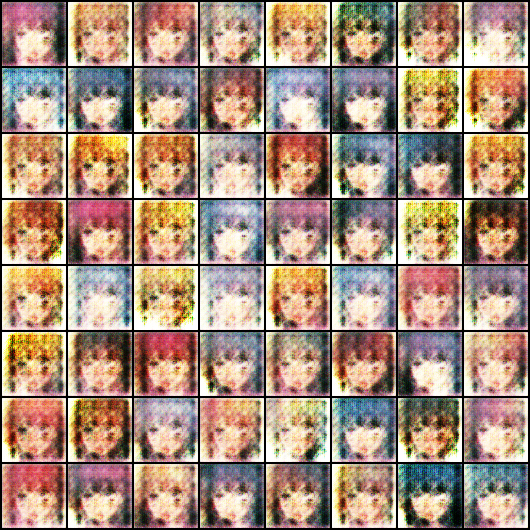

In [ ]:
Image('./generated/generated-images-0001.png')

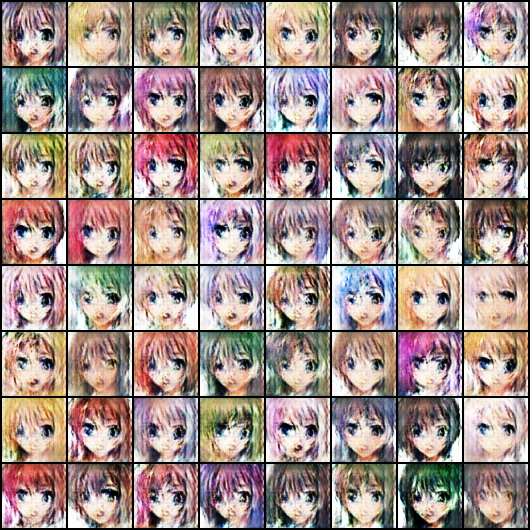

In [ ]:
Image('./generated/generated-images-0005.png')

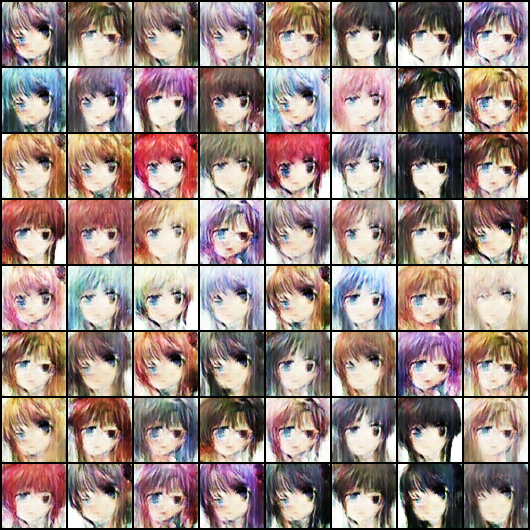

In [ ]:
Image('./generated/generated-images-0010.png')


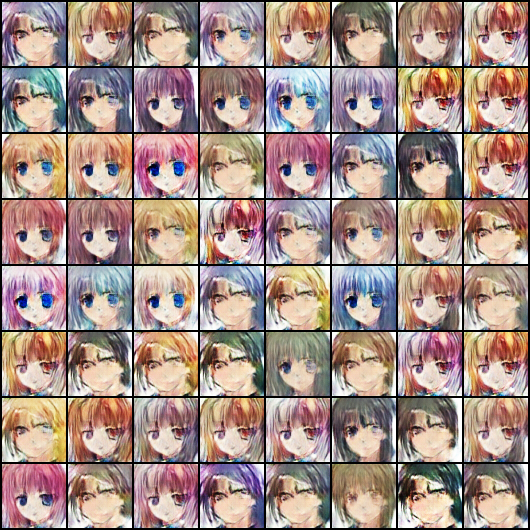

In [ ]:
Image('./generated/generated-images-0020.png')


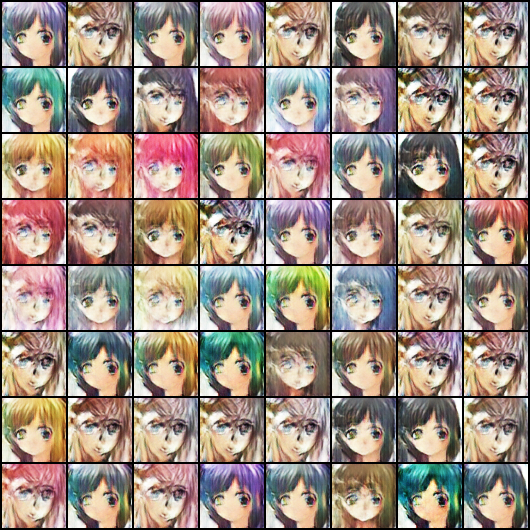

In [ ]:
Image('./generated/generated-images-0025.png')